In [5]:
import matplotlib.pyplot as plt
import numpy as np


# read data into memory
data_set_train = np.genfromtxt("hw04_data_set_train.csv", delimiter = ",", skip_header = 1)
data_set_test = np.genfromtxt("hw04_data_set_test.csv", delimiter = ",", skip_header = 1)

# get x and y values
X_train = data_set_train[:, 0:1]
y_train = data_set_train[:, 1]
X_test = data_set_test[:, 0:1]
y_test = data_set_test[:, 1]

# set drawing parameters
minimum_value = 1.5
maximum_value = 5.1
step_size = 0.001
X_interval = np.arange(start = minimum_value, stop = maximum_value + step_size, step = step_size)
X_interval = X_interval.reshape(len(X_interval), 1)

def plot_figure(X_train, y_train, X_test, y_test, X_interval, y_interval_hat):
    fig = plt.figure(figsize = (8, 4))
    plt.plot(X_train[:, 0], y_train, "b.", markersize = 10)
    plt.plot(X_test[:, 0], y_test, "r.", markersize = 10)
    plt.plot(X_interval[:, 0], y_interval_hat, "k-")
    plt.xlabel("Eruption time (min)")
    plt.ylabel("Waiting time to next eruption (min)")
    plt.legend(["training", "test"])
    plt.show()
    return(fig)

In [6]:

def decision_tree_regression_train(X_train, y_train, min_samples_split):
    # Create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}

    node_features = {}
    node_splits = {}
    node_means = {}

    # Implementation starts below
    D = X_train.shape[1]
    root_node = 1
    node_indices[root_node] = np.array(range(X_train.shape[0]))
    is_terminal[root_node] = False
    need_split[root_node] = True

    while True:
        split_nodes = [key for key, value in need_split.items() if value]
        if not split_nodes:
            break

        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            node_means[split_node] = np.mean(y_train[data_indices])

            if len(data_indices) <= min_samples_split:
                is_terminal[split_node] = True
                continue

            best_score = np.inf
            best_split = None
            best_d = None

            for d in range(D):
                unique_values = np.sort(np.unique(X_train[data_indices, d]))
                split_positions = (unique_values[1:] + unique_values[:-1]) / 2

                for split in split_positions:
                    left_indices = data_indices[X_train[data_indices, d] > split]
                    right_indices = data_indices[X_train[data_indices, d] <= split]
                    left_score = np.sum((y_train[left_indices] - np.mean(y_train[left_indices])) ** 2)
                    right_score = np.sum((y_train[right_indices] - np.mean(y_train[right_indices])) ** 2)
                    score = left_score + right_score

                    if score < best_score:
                        best_score = score
                        best_split = split
                        best_d = d

            node_features[split_node] = best_d
            node_splits[split_node] = best_split
            is_terminal[split_node] = False

            left_indices = data_indices[X_train[data_indices, best_d] > best_split]
            right_indices = data_indices[X_train[data_indices, best_d] <= best_split]

            left_node = 2 * split_node
            right_node = 2 * split_node + 1

            node_indices[left_node] = left_indices
            is_terminal[left_node] = False
            need_split[left_node] = True

            node_indices[right_node] = right_indices
            is_terminal[right_node] = False
            need_split[right_node] = True

    # Implementation ends above
    return is_terminal, node_features, node_splits, node_means


In [20]:
# STEP 3
# Assuming that there are N query data points
# Should return a numpy array with shape (N,)
def decision_tree_regression_test(X_query, is_terminal, node_features, node_splits, node_means):
    # Implementation starts below
    N = X_query.shape[0]
    y_predicted = np.empty(N)

    for i in range(N):
        index = 1
        while not is_terminal[index]:
            index = 2 * index + (0 if X_query[i] > node_splits[index] else 1)

        y_predicted[i] = node_means[index]

    y_hat = np.array(y_predicted)
    # Implementation ends above
    return y_hat

# STEP 4
# assuming that there are T terminal node
# should print T rule sets as described
def extract_rule_sets(is_terminal, node_features, node_splits, node_means):
    # Implementation starts below
    terminal_nodes = [key for key, value in is_terminal.items() if value]
    
    for terminal_node in terminal_nodes:
        index = terminal_node
        rules = []

        while index > 1:
            parent = index // 2
            feature = node_features[parent] + 1
            split_value = node_splits[parent]

            rule = f"x{feature} {'>' if index % 2 == 0 else '<='} {split_value:.2f}"
            rules.append(rule)
            index = parent

        rules = reversed(rules)
        rule_set = ", ".join(rules)
        print(f"Node {terminal_node:02d}: {rule_set} => {node_means[terminal_node]}")
    # Implementation ends above

In [21]:
P = 20
is_terminal, node_features, node_splits, node_means = decision_tree_regression_train(X_train, y_train, P)
y_interval_hat = decision_tree_regression_test(X_interval, is_terminal, node_features, node_splits, node_means)
fig = plot_figure(X_train, y_train, X_test, y_test, X_interval, y_interval_hat)
fig.savefig("decision_tree_regression_{}.pdf".format(P), bbox_inches = "tight")

y_train_hat = decision_tree_regression_test(X_train, is_terminal, node_features, node_splits, node_means)
rmse = np.sqrt(np.mean((y_train - y_train_hat)**2))
print("RMSE on training set is {} when P is {}".format(rmse, P))

y_test_hat = decision_tree_regression_test(X_test, is_terminal, node_features, node_splits, node_means)
rmse = np.sqrt(np.mean((y_test - y_test_hat)**2))
print("RMSE on test set is {} when P is {}".format(rmse, P))


AttributeError: 'dict' object has no attribute 'shape'

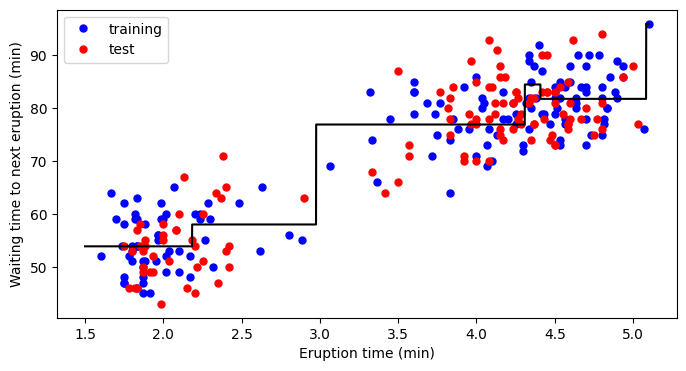

RMSE on training set is 5.00414678298864 when P is 50
RMSE on test set is 6.328291469197311 when P is 50
Node 05: x1 > 2.98, x1 <= 4.31 => 76.92105263157895
Node 06: x1 <= 2.98, x1 > 2.18 => 58.0
Node 07: x1 <= 2.98, x1 <= 2.18 => 53.86363636363637
Node 08: x1 > 2.98, x1 > 4.31, x1 > 5.08 => 96.0
Node 18: x1 > 2.98, x1 > 4.31, x1 <= 5.08, x1 > 4.41 => 81.77777777777777
Node 19: x1 > 2.98, x1 > 4.31, x1 <= 5.08, x1 <= 4.41 => 84.5


In [19]:
P = 50
is_terminal, node_features, node_splits, node_means = decision_tree_regression_train(X_train, y_train, P)
y_interval_hat = decision_tree_regression_test(X_interval, is_terminal, node_features, node_splits, node_means)
fig = plot_figure(X_train, y_train, X_test, y_test, X_interval, y_interval_hat)
fig.savefig("decision_tree_regression_{}.pdf".format(P), bbox_inches = "tight")

y_train_hat = decision_tree_regression_test(X_train, is_terminal, node_features, node_splits, node_means)
rmse = np.sqrt(np.mean((y_train - y_train_hat)**2))
print("RMSE on training set is {} when P is {}".format(rmse, P))

y_test_hat = decision_tree_regression_test(X_test, is_terminal, node_features, node_splits, node_means)
rmse = np.sqrt(np.mean((y_test - y_test_hat)**2))
print("RMSE on test set is {} when P is {}".format(rmse, P))

extract_rule_sets(is_terminal, node_features, node_splits, node_means)